# Overview


We are going to recognize hand gestures from a video sequence. To recognize these gestures from a live video sequence, we need to do three things...
1.  We, first need to segment the hand region alone removing all the unwanted portions in the video sequence. 
2.  After segmenting the hand region, we then pass that region to the trained 2D CNN model, to predict the hand gesture.

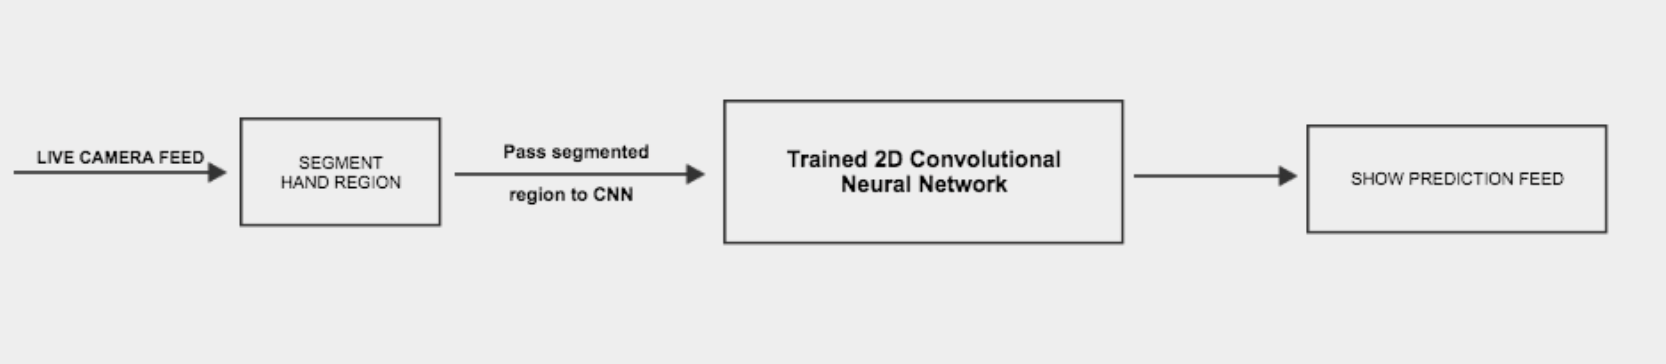

# Segment the Hand region

The first step in hand gesture recognition is obviously to find the hand region by eliminating all the other unwanted portions in the video sequence. 

In order to get the segment, we do three things 

- Background Subtraction
- Motion Detection and Thresholding
- Contour Extraction


### Background Subtraction
Background Subtraction là kỹ thuật được sử dụng trong Computer Vision để tách đối tượng di chuyển khỏi nền tĩnh trong video hoặc chuỗi ảnh. Quá trình này giúp nhận diện sự thay đổi giữa khung hình hiện tại và khung nền (background), từ đó phát hiện các vật thể chuyển động.

Nguyên lý:

Tạo ra một "mặt nạ" chứa các vùng có sự thay đổi lớn về pixel giữa nền tĩnh và khung hình hiện tại.
Nền có thể được mô hình hóa bằng cách sử dụng các kỹ thuật như Adaptive Gaussian Mixture Models (GMM), hoặc đơn giản là cập nhật nền tĩnh theo thời gian.
Ứng dụng:

Giám sát an ninh, phát hiện vật thể chuyển động (xe cộ, người đi bộ).
Xác định đối tượng di chuyển trong video.


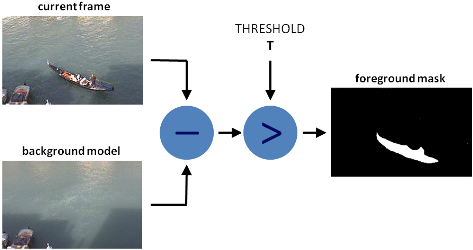




### Motion Detection (Phát hiện chuyển động)
Motion Detection là quá trình phát hiện sự thay đổi trong khung hình của một video hoặc chuỗi ảnh, qua đó xác định sự di chuyển của các vật thể.

Nguyên lý:

Dựa vào việc so sánh hai hoặc nhiều khung hình liên tiếp để tìm ra những sự khác biệt đáng kể về pixel, biểu thị sự di chuyển.
Frame Differencing là một kỹ thuật phổ biến, tính sự chênh lệch giữa hai khung hình liên tiếp.
Ứng dụng:

Hệ thống giám sát an ninh, phát hiện và cảnh báo khi có chuyển động.
Ứng dụng trong xe tự hành, theo dõi đối tượng di chuyển.
### Thresholding (Ngưỡng hóa hình ảnh)
Thresholding là một kỹ thuật trong xử lý ảnh để phân đoạn ảnh thành hai phần: các vùng pixel trên ngưỡng và dưới ngưỡng. Điều này giúp tách rõ các đối tượng ra khỏi nền.

Nguyên lý:

Một giá trị ngưỡng được xác định. Mỗi pixel trong ảnh sẽ được kiểm tra với giá trị ngưỡng đó:
Pixel có giá trị lớn hơn ngưỡng sẽ được gán màu trắng (255).
Pixel có giá trị nhỏ hơn ngưỡng sẽ được gán màu đen (0).
Ứng dụng:

Phân đoạn ảnh, tách vật thể khỏi nền.
Nhận diện chữ viết (OCR), xử lý ảnh đen trắng.



### Contour Extraction (Trích xuất đường viền)
Contour Extraction là quá trình tìm và vẽ các đường viền bao quanh các đối tượng trong ảnh. Nó rất hữu ích trong việc phát hiện biên giới của vật thể và nhận diện hình dạng.

Nguyên lý:

Sau khi áp dụng threshold hoặc background subtraction, các contour có thể được phát hiện bằng cách tìm các đường biên của đối tượng.
OpenCV cung cấp hàm findContours() để tìm kiếm các đường viền.
Ứng dụng:

Phát hiện hình dạng, nhận diện đối tượng trong ảnh.
Theo dõi đối tượng trong video, đếm số lượng đối tượng.

#### Note: Contour is the outline or boundary of an object located in an image.



In [1]:
import cv2
import numpy as np
import os

import datetime
from skimage import io
import os
import random
import matplotlib.pyplot as plt
%matplotlib inline
import glob # tìm kiếm các tệp tin dựa trên pattern matching(so khớp mẫu)

In [2]:

np.random.seed(30)
import random as rn


import tensorflow as tf


### Test cam

In [3]:
# # Starts capturing video
# cap = cv2.VideoCapture(0)

# fps = int(cap.get(cv2.CAP_PROP_FPS))

# print("Frames per second using video.get(cv2.CAP_PROP_FPS) : {0}".format(fps))

# while cap.isOpened():
#     ret, frame = cap.read()
#     cv2.imshow('Captured Frame', frame)
#     if cv2.waitKey(1) == ord('q'):
#         break

#     keypress = cv2.waitKey(1) & 0xFF

# cap.release()
# cv2.destroyAllWindows()


Frames per second using video.get(cv2.CAP_PROP_FPS) : 30


### Load dataset

In [3]:
# Loading the Dataset
# https://www.kaggle.com/datasets/roobansappani/hand-gesture-recognition
DATASET_PATH = "../lab1/dataset/HandGesture/images"

dataset_path = os.path.join(DATASET_PATH, '*')
dataset_path = glob.glob(dataset_path)
list_of_gestures = [os.path.basename(folder_path) for folder_path in dataset_path]
print(list_of_gestures)

['call_me', 'fingers_crossed', 'okay', 'paper', 'peace', 'rock', 'rock_on', 'scissor', 'thumbs', 'up']


### show images from dataset

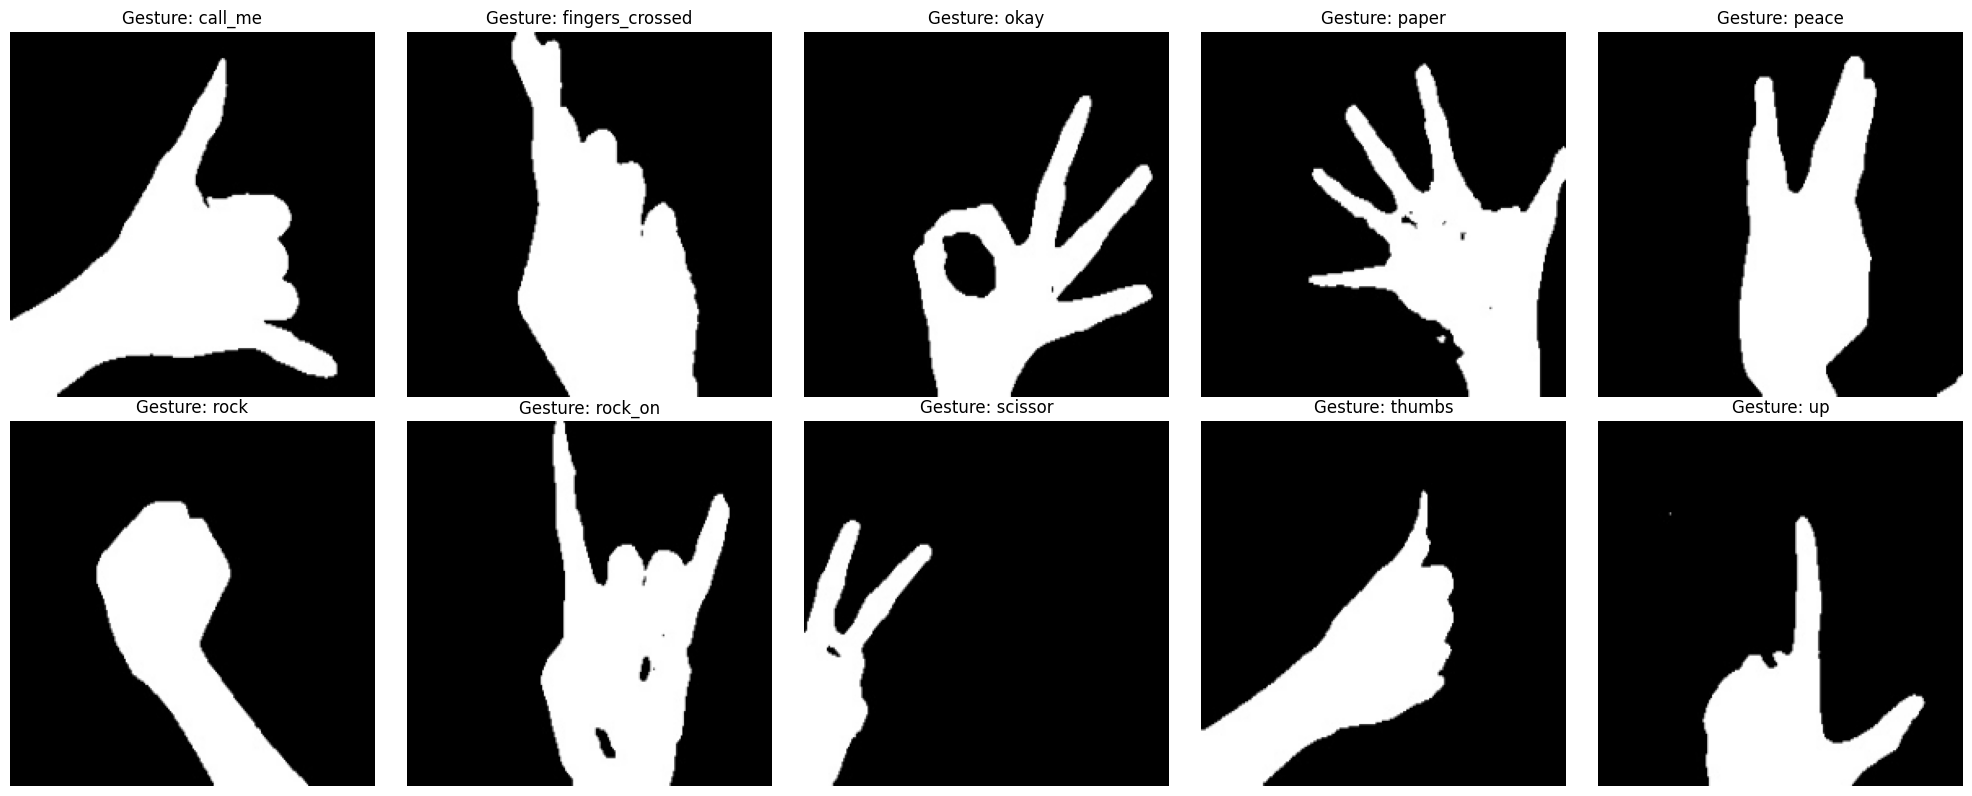

In [5]:

def display_images_grid(dataset_path,list_of_gestures, num_cols=5):
    """
    Hiển thị các ảnh trong dạng lưới.

    Parameters:
    - dataset_path (str): Đường dẫn đến thư mục chứa các tập dữ liệu ảnh.
    - num_cols (int): Số lượng ảnh mỗi hàng.
    """
    
    # Tính số hàng cần thiết
    num_rows = (len(list_of_gestures) + num_cols - 1) // num_cols
    
    # Tạo hình ảnh lưới
    fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(20, 4 * num_rows))
    
    # Chuyển đổi axes thành một danh sách 1D để thuận tiện
    axes = axes.flatten()
    
    for i, ax in enumerate(axes):
        if i < len(list_of_gestures):
            dataset_path_images = os.path.join(dataset_path, list_of_gestures[i])
            gesture_path_images = os.path.join(dataset_path_images, '*')
            gest_path_images = glob.glob(gesture_path_images)
            
            if gest_path_images:
                # Đọc và thay đổi kích thước ảnh đầu tiên trong danh sách
                image = cv2.imread(gest_path_images[0])
                image = cv2.resize(image, (224, 224))
                
                # Chuyển đổi ảnh từ BGR sang RGB
                image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                
                # Hiển thị ảnh trên lưới
                ax.imshow(image_rgb)
                ax.set_title(f'Gesture: {list_of_gestures[i]}')
                ax.axis('off')
        else:
            # Ẩn các ô không sử dụng
            ax.axis('off')
    
    # Điều chỉnh khoảng cách giữa các hình
    plt.tight_layout()
    plt.show()
display_images_grid(dataset_path='../lab1/dataset/HandGesture/images/',list_of_gestures=list_of_gestures)

### Create list of all images

In [6]:
loaded_images_vgg16 = []

for path in range( len(dataset_path)):
    dataset_path_images = "../lab1/dataset/HandGesture/images/" + str(list_of_gestures[path])
    gesture_path_images = os.path.join(dataset_path_images, '*')
    gest_path_images = glob.glob(gesture_path_images)
    print(gest_path_images)
    k=0
    for i in range(len(gest_path_images)):
        if k<=499:
            image = cv2.imread(gest_path_images[i])
            image = cv2.resize(image,(224, 224))
            loaded_images_vgg16.append(image)
        k+=1
len(loaded_images_vgg16)

['../lab1/dataset/HandGesture/images/call_me\\1055.jpg', '../lab1/dataset/HandGesture/images/call_me\\1070.jpg', '../lab1/dataset/HandGesture/images/call_me\\1086.jpg', '../lab1/dataset/HandGesture/images/call_me\\1101.jpg', '../lab1/dataset/HandGesture/images/call_me\\1115.jpg', '../lab1/dataset/HandGesture/images/call_me\\1129.jpg', '../lab1/dataset/HandGesture/images/call_me\\1151.jpg', '../lab1/dataset/HandGesture/images/call_me\\1186.jpg', '../lab1/dataset/HandGesture/images/call_me\\1233.jpg', '../lab1/dataset/HandGesture/images/call_me\\1245.jpg', '../lab1/dataset/HandGesture/images/call_me\\1281.jpg', '../lab1/dataset/HandGesture/images/call_me\\1293.jpg', '../lab1/dataset/HandGesture/images/call_me\\1303.jpg', '../lab1/dataset/HandGesture/images/call_me\\1314.jpg', '../lab1/dataset/HandGesture/images/call_me\\1327.jpg', '../lab1/dataset/HandGesture/images/call_me\\1581.jpg', '../lab1/dataset/HandGesture/images/call_me\\1591.jpg', '../lab1/dataset/HandGesture/images/call_me\\16

5000

### Check list of images

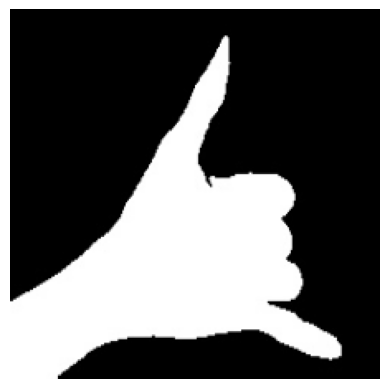

In [9]:
import matplotlib.pyplot as plt

# Chọn ảnh thứ nhất trong loaded_images
image = loaded_images_vgg16[0]

# Chuyển đổi từ BGR sang RGB
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Hiển thị ảnh
plt.imshow(image_rgb)
plt.axis('off')  # Tắt trục
plt.show()


### create vector for each of class

In [7]:
import numpy as np

# Số lượng lớp
num_classes = 10
list_class = ['call_me', 'fingers_crossed', 'okay', 'paper', 'peace', 'rock', 'rock_on', 'scissor', 'thumbs', 'up']

# Danh sách số lượng ảnh trong mỗi lớp
num_images_per_class = 500

# Tạo outputVectors cho mỗi lớp
output_vectors = []
for class_idx in range(num_classes):
    # Tạo vector one-hot cho lớp hiện tại
    one_hot_vector = np.zeros(num_classes)
    one_hot_vector[class_idx] = 1
    
    # Lặp lại vector one-hot theo số lượng ảnh trong lớp hiện tại
    output_vectors.extend([one_hot_vector] * num_images_per_class)

# Chuyển đổi danh sách thành mảng NumPy
output_vectors = np.array(output_vectors)

print(output_vectors)  # In kích thước của output_vectors để xác minh


[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]


### Create training and label vector

In [8]:

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

X = np.array(loaded_images_vgg16)
y = np.array(output_vectors)
# print(X.shape)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)




print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(4000, 224, 224, 3)
(4000, 10)
(1000, 224, 224, 3)
(1000, 10)


In [9]:
# Tạo ImageDataGenerator
datagen = ImageDataGenerator(
    rescale=1/255.0,         
    horizontal_flip=True, 
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.3,
    validation_split=0.2
)
# Tạo generator cho huấn luyện và kiểm tra
train_generator = datagen.flow(X_train, y_train, subset='training', batch_size=32)
validation_generator = datagen.flow(X_test, y_test, subset='validation', batch_size=32)

# Train and predict hand gesture with 2D CNN Model

In [11]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten,BatchNormalization,Dropout
from tensorflow.keras.models import Sequential

# Số lớp phân loại của bạn (cần điều chỉnh theo số lớp trong bài toán của bạn)
num_classes = 10

  # load pretrained model 'VGG16'
base_model=VGG16(
include_top=False,
weights="imagenet",
input_shape=(224, 224 ,3))
# trainable = False
base_model.trainable = False

model_vgg16=Sequential()
model_vgg16.add(base_model)
model_vgg16.add(BatchNormalization())   # batch normalization
model_vgg16.add(Dropout(0.25))           # dropout for preventing overfitting
model_vgg16.add(Flatten())
model_vgg16.add(Dense(256,activation='relu',kernel_initializer='he_normal'))
model_vgg16.add(Dropout(0.25))
model_vgg16.add(Dense(num_classes,activation='softmax',kernel_initializer='glorot_normal'))    

model_vgg16.compile(optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['accuracy'])
  

model_vgg16.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 batch_normalization (BatchN  (None, 7, 7, 512)        2048      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 7, 7, 512)         0         
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 256)               6422784   
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                        

In [13]:
# Training the model with data
history=model_vgg16.fit(train_generator,
          batch_size=32,
          epochs=10,
          verbose=1,
          validation_data=validation_generator)

model_vgg16.save("hand_gesture_recognition_vgg16.h5")

Epoch 1/10
100/100 [==============================] - 40s 301ms/step - loss: 1.0017 - accuracy: 0.7472 - val_loss: 0.7620 - val_accuracy: 0.7600
Epoch 2/10
100/100 [==============================] - 29s 291ms/step - loss: 0.3963 - accuracy: 0.8828 - val_loss: 0.3004 - val_accuracy: 0.8950
Epoch 3/10
100/100 [==============================] - 31s 313ms/step - loss: 0.2773 - accuracy: 0.9219 - val_loss: 0.1640 - val_accuracy: 0.9600
Epoch 4/10
100/100 [==============================] - 30s 301ms/step - loss: 0.2496 - accuracy: 0.9284 - val_loss: 0.1761 - val_accuracy: 0.9450
Epoch 5/10
100/100 [==============================] - 31s 306ms/step - loss: 0.2732 - accuracy: 0.9300 - val_loss: 0.0913 - val_accuracy: 0.9700
Epoch 6/10
100/100 [==============================] - 32s 314ms/step - loss: 0.2103 - accuracy: 0.9428 - val_loss: 0.0820 - val_accuracy: 0.9700
Epoch 7/10
100/100 [==============================] - 31s 311ms/step - loss: 0.1988 - accuracy: 0.9459 - val_loss: 0.1219 - val_ac

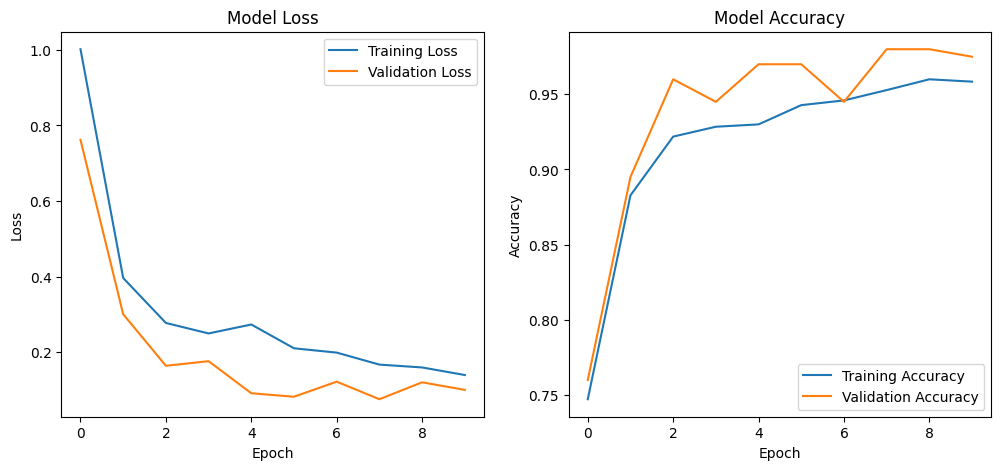

In [14]:
import matplotlib.pyplot as plt

# Trực quan hóa loss và accuracy
def plot_training_history(history):
    plt.figure(figsize=(12, 5))
    
    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    
    # Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    
    plt.show()

# Gọi hàm để vẽ đồ thị
plot_training_history(history)


In [16]:
[loss, acc] = model_vgg16.evaluate((validation_generator),verbose=1)
print("Accuracy: " + str(acc))

3/3 [==============================] - 1s 113ms/step - loss: 0.0018 - accuracy: 1.0000
Accuracy: 1.0


1/1 [==============================] - 0s 224ms/step


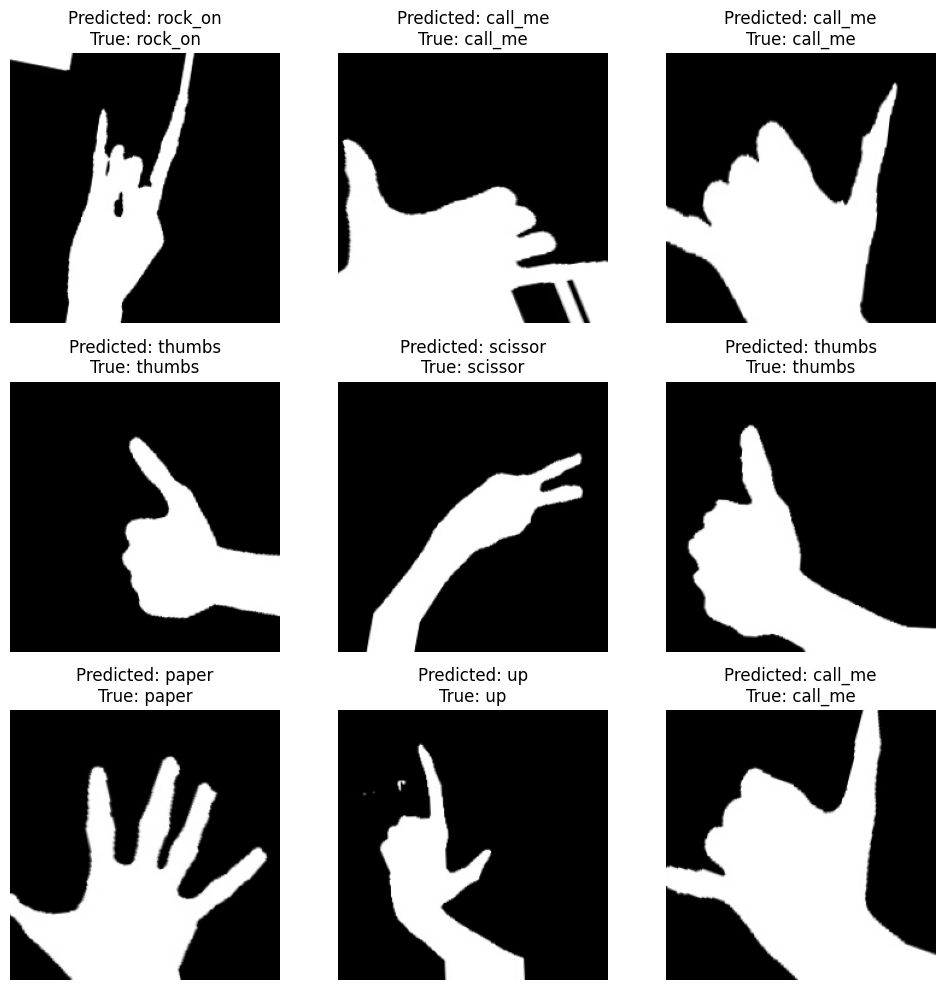

In [15]:
import numpy as np
import matplotlib.pyplot as plt

# Lấy một batch từ train_generator
X_batch, y_batch = next(train_generator)

# Dự đoán bằng mô hình
predictions = model_vgg16.predict(X_batch)

# Lấy nhãn dự đoán (lấy nhãn có xác suất cao nhất)
predicted_classes = np.argmax(predictions, axis=1)

# Lấy nhãn thực tế
true_classes = np.argmax(y_batch, axis=1)

# Hiển thị một số ảnh trong batch cùng với nhãn dự đoán và nhãn thực tế
plt.figure(figsize=(10, 10))
for i in range(9):  # Hiển thị 9 ảnh đầu tiên
    plt.subplot(3, 3, i+1)
    plt.imshow(X_batch[i])
    plt.title(f"Predicted: {list_class[predicted_classes[i]]}\nTrue: {list_class[true_classes[i]]}")
    plt.axis('off')

plt.tight_layout()
plt.show()


## Run LIVE FEED

In [1]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model


# Tải mô hình đã lưu
model_vgg16 = load_model("hand_gesture_recognition_vgg16.h5")

# Danh sách lớp của bạn
list_class = ['call_me', 'fingers_crossed', 'okay', 'paper', 'peace', 'rock', 'rock_on', 'scissor', 'thumbs', 'up']


def preprocess_frame(frame):
    # Chuyển đổi khung hình sang kích thước mong muốn và chuẩn hóa
    img = cv2.resize(frame, (224, 224))
    img = img / 255.0
    img = np.expand_dims(img, axis=0)  # Thay đổi kích thước thành (1, 224, 224, 3)
    # img = preprocess_input(img)  # Tiền xử lý cho VGG16
    return img

def detect_objects(frame):
    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
    lower_skin = np.array([0, 20, 70], dtype=np.uint8)
    upper_skin = np.array([20, 255, 255], dtype=np.uint8)
    mask = cv2.inRange(hsv, lower_skin, upper_skin)
    contours, _ = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    bboxes = []
    for contour in contours:
        if cv2.contourArea(contour) > 10000:
            (x, y, w, h) = cv2.boundingRect(contour)
            bboxes.append((x, y, w, h))
            cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)
    
    return bboxes

# Mở webcam
cap = cv2.VideoCapture(0)

while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Phát hiện đối tượng và lấy các khung bao
    bboxes = detect_objects(frame)

    for (x, y, w, h) in bboxes:
        # Cắt vùng khuôn mặt từ khung hình
        roi = frame[y:y+h, x:x+w]
        # Tiền xử lý cho dự đoán
        preprocessed_roi = preprocess_frame(roi)
        # Dự đoán lớp
        predictions = model_vgg16.predict(preprocessed_roi)
        predicted_class = np.argmax(predictions, axis=1)[0]
        predicted_label = list_class[predicted_class]
        
        # Hiển thị lớp dự đoán trên khung chữ nhật
        cv2.putText(frame, predicted_label, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2, cv2.LINE_AA)

    # Hiển thị khung hình
    cv2.imshow('Hand Gesture Detection', frame)

    # Thoát nếu nhấn phím 'q'
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Giải phóng tài nguyên
cap.release()
cv2.destroyAllWindows()


1/1 [==============================] - 0s 20ms/step


In [3]:
import cv2

# Mở camera (0 là camera mặc định)
cap = cv2.VideoCapture(0)

# Kiểm tra xem camera có mở thành công không
if not cap.isOpened():
    print("Không thể mở camera.")
else:
    # Lấy độ phân giải của camera
    width = cap.get(cv2.CAP_PROP_FRAME_WIDTH)
    height = cap.get(cv2.CAP_PROP_FRAME_HEIGHT)
    
    print(f"Độ phân giải của camera: {width} x {height}")

    # Đóng camera
    cap.release()

# Đóng tất cả các cửa sổ OpenCV
cv2.destroyAllWindows()


Độ phân giải của camera: 640.0 x 480.0
